In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from activ.ct.summarize import _check_pca, plot_overall_leverage, plot_measure_leverage, top_components, load_data, get_age_sex

In [2]:
Xdf, metadata_df = load_data('115Label.csv', '../TRACKTBI_Pilot_DEID_02.22.18v2_LN_8.17.18.csv', 
                             filter_suffixes = ('Sum', 'Min', 'Max', 'Q05', 'Q95', 'PHY'), normalize=True)

#### Extract age and sex

In [3]:
age, sex = get_age_sex(metadata_df['PatientType'])

## PCA

In [4]:
pca = _check_pca(Xdf.values, None)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

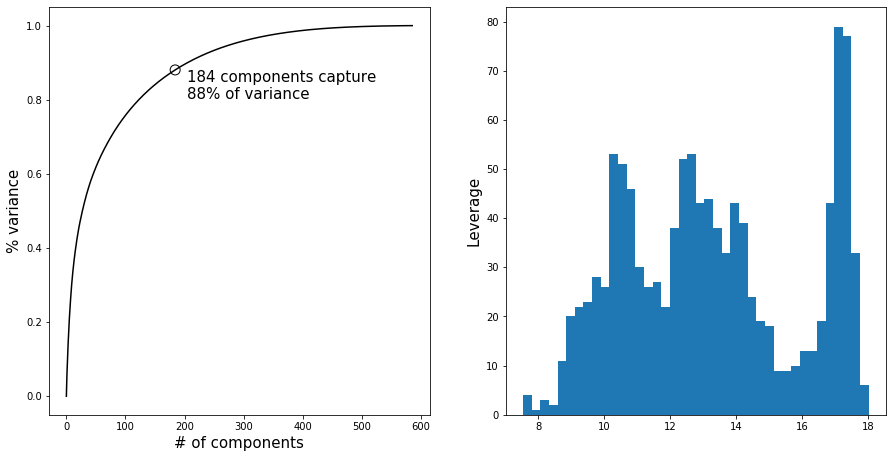

In [5]:
plt.figure(figsize=(15, 7.5))
plot_overall_leverage(pca=pca)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

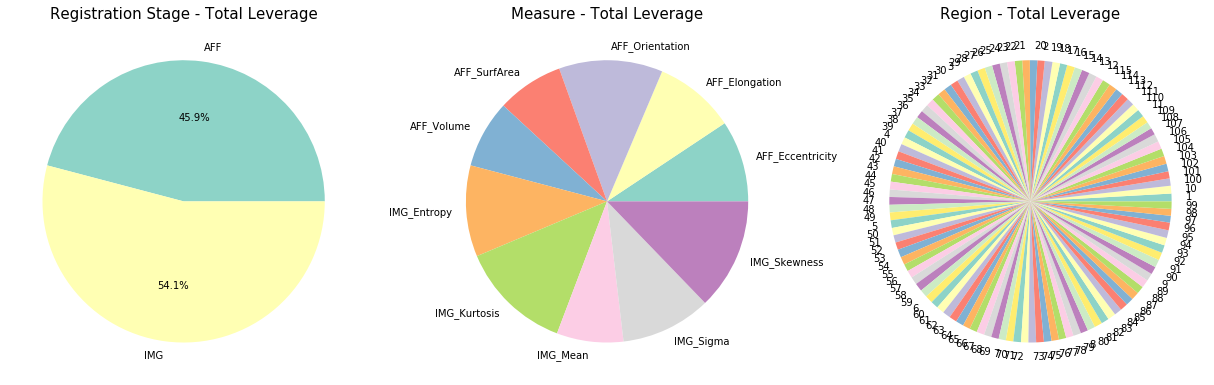

In [6]:
plt.figure(figsize=(21.5, 7.5))
plot_measure_leverage(pca=pca, measures=Xdf.columns)

In [7]:
Xpca, pca_df = top_components(Xdf, pca)

## UMAP

In [8]:
from umap import UMAP
umap = UMAP(n_components=2, min_dist=0.0, random_state=1000)
emb = umap.fit_transform(Xdf.values)

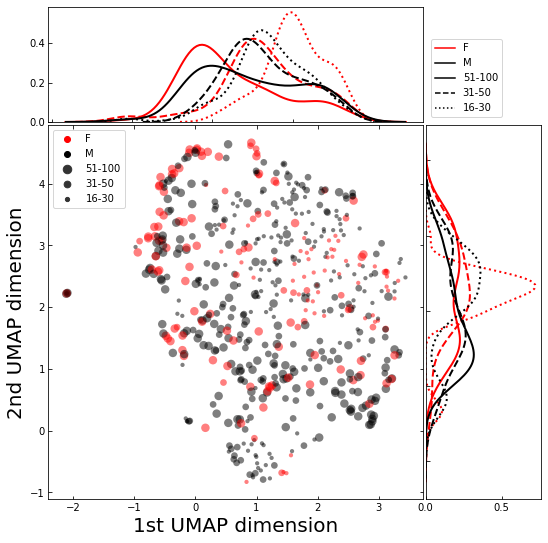

In [9]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
plt.figure(figsize=(8, 8))

from activ.ct.summarize import plot_umap

plot_umap(emb, age, sex, sp_kwargs=dict(linewidth=0, alpha=0.5), path='115Label/summary/umap.IMG_AFF.png', sf_kwargs={'dpi':300})
    
#plt.savefig('CT_measures_UMAP_w_hist.png', dpi=300)

In [10]:
mask = emb[:,0] < -1.2
print(metadata_df.iloc[mask])

        PatientType GCSMildModSevereRecode
PI-1015     M_16_30           Severe (3-8)
PI-1052     F_31_50           Severe (3-8)
PI-1075     M_16_30           Mild (13-15)
PI-1103    M_51_100           Mild (13-15)
PI-1137    F_51_100           Severe (3-8)
PI-1145    M_51_100           Severe (3-8)


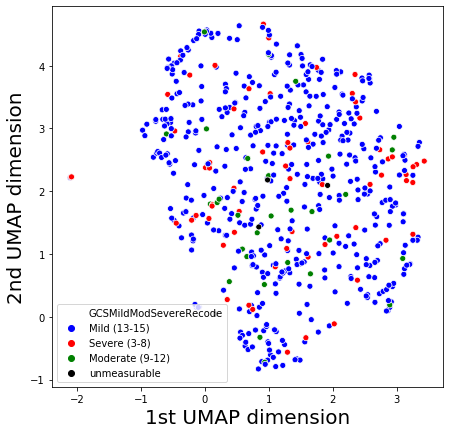

In [11]:
plt.figure(figsize=(7,7))
from activ.ct.summarize import plot_gcs

plot_gcs(emb, metadata_df['GCSMildModSevereRecode'])
#plt.savefig('CT_measures_UMAP.eps')

## Supervised Learning

In [12]:
from activ import load_data

# Remove any patients not in the imaging results
tbidata = load_data()
bm = tbidata.biomarkers
oc = tbidata.outcomes
patient_ids = tbidata.patient_ids
mask = np.ones(patient_ids.shape[0], dtype=bool)
keep = set(Xdf.index)
for i, pid in enumerate(patient_ids):
    if pid not in keep:
        mask[i] = False

bm = bm[mask]
oc = oc[mask]
subset_pids = patient_ids[mask]
patient_mask = mask
print(oc.shape[0], "patients with outcomes")
print(subset_pids.shape[0], "patient IDs")

246 patients with outcomes
246 patient IDs


In [13]:
from activ.cca.alscca import ALSCCA
from activ.cca import cross_decomp_scatter
sparse_cca = ALSCCA(random_state=10, alpha=0.15)
Xdf_w_ocs = Xdf.filter(patient_ids, axis=0)
z, s = sparse_cca.fit(Xdf_w_ocs, oc).transform(Xdf_w_ocs, oc)

/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.883930021792878, tolerance: 0.4714949282842903
  positive)
/Users/ajtritt/anaconda/envs/activ_37/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.883930021792878, tolerance: 0.4714949282842903
  positive)


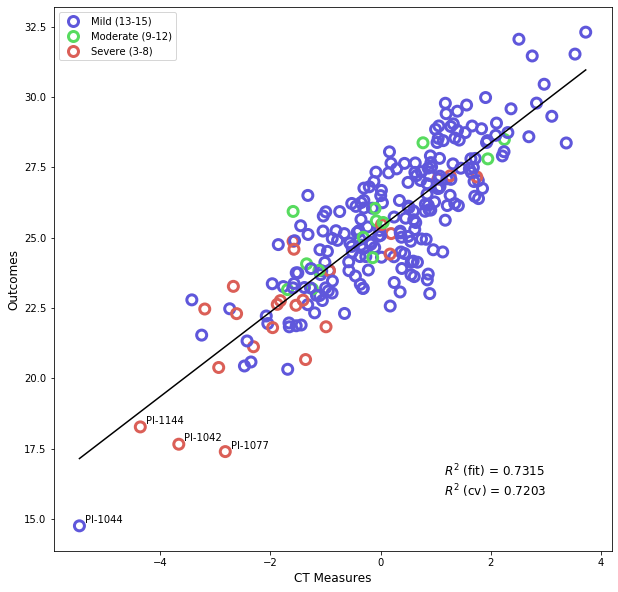

In [14]:
plt.figure(figsize=(10,10))
cross_decomp_scatter(z.values, s, solid_points=False,
                    labels=metadata_df.filter(patient_ids, axis=0)['GCSMildModSevereRecode'], 
                    xlabel="CT Measures", ylabel="Outcomes",
                    fontsize=12,
                    markersize=10,
                    markeredgewidth=3)

# add labels to the outliers
mask = s < 19
for i in np.where(mask)[0]:
    plt.text(z[i]+0.1, s[i]+0.1, Xdf_w_ocs.index[i])

#plt.savefig("115Label/summary/cca.IMG_AFF.vs.outcomes.png", dpi=300)